# Importing libs

In [1]:
import sys, os
import numpy as np
import pandas as pd
from copy import deepcopy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir))) # if you run this notebook from its current folder on our GitHub, you may need this line
from utils.genlink import DataProcessor # core class, all graphs are processed there
from utils.genlink import Trainer # you can train your nets using our algorithms with this class
from utils.genlink import NullSimulator # you can simulate graphs with that class
from utils.models import GL_TAGConv_3l_512h_w_k3_gnorm # here is one of our best gnn, see all available classes in utils.models, they all can be used absolutely identical

In [2]:
# let's also fix our seed globally
seed = 42

Disclamer: there are not so many internal code asserts across current GENLINK repository, so, please, follow instructions as all this code is not designed to work with what it's not designed to work for :)

# Graph simulation and visualization

Let's simulate very simple graph with 4 populations. Initially, you need to pass 3 arguments to the `NullSimulator` class:

* `num_classes` - how many populations you want to simulat (int)
* `edge_probs` - edge probability between every population, should be matrix with the shape `(num_classes, num_classes)`, each values must be less than 1.0, there are no any additional reuirements
* `mean_weight` - $\lambda$ paramener (mean) in exponential distribution, should be matrix with the shape `(num_classes, num_classes)`, we will sample edge weights from exponential distribution

Remember that `edge_probs[i, j]` relate to `mean_weight[i, j]` and both matrices must be symmetrical

In [3]:
ep = np.array([[0.48, 0.02, 0.01, 0.02],
               [0.02, 0.12, 0.1, 0.08],
               [0.01, 0.1, 0.56, 0.32],
               [0.02, 0.08, 0.32, 0.61]])

mw = np.array([[29.16, 10.77, 10.05, 11.54],
               [10.77, 14.13, 12.49, 12.21],
               [10.05, 12.49, 24.76, 19.13],
               [11.54, 12.21, 19.13, 31.08]])

In [4]:
assert np.all(ep == ep.T)
assert np.all(mw == mw.T)

In [5]:
ns = NullSimulator(num_classes=4, 
                   edge_probs=ep, 
                   mean_weight=mw)

Now you need to specify population sizes and generate internal simulator objects (`counts, means, pop_index`). Assuming `ns` is you `NullSimulator` object, you should call `generate_matrices` method that takes:

* `population_sizes` - a numpy array with the desired number of individuals in each population (its like `population_sizes[i]` relate to `edge_probs[i, i]` and `mean_weights[i, i]`)
* `rng` - just numpy random number generator, fixed by seed

In [6]:
ps = np.array([12, 20, 16, 8])

In [7]:
counts, means, pop_index = ns.generate_matrices(population_sizes=ps,
                                                rng=np.random.default_rng(seed))

Finally, call `simulate_graph` method. Specify the path you want to save you graph to

In [8]:
graph_file_path = f'{os.environ.get("HOME")}/GENLINK/data/tutorial/tutorial_graph.csv'
ns.simulate_graph(means=means,
                  counts=counts, 
                  pop_index=pop_index,
                  path=graph_file_path)

Now you get the graph in readable `.csv` format where each row contains edge with its properties. Here is column breakdown:

* `node_id1` - name of node in simulated graph
* `node_id2` - name of node in simulated graph
* `label_id1` - name of population in simulated graph that node in `node_id1` belongs to
* `label_id2` - name of population in simulated graph that node in `node_id2` belongs to
* `ibd_sum` - as each row is an edge, so this is an edge weight
* `ibd_n` - number of IBD segments, it's always 1 because we can't simulate them (keep just for consistency with real data)

In [9]:
pd.read_csv(graph_file_path)

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
230,node_55,node_47,P3,P2,6.396516,1
231,node_55,node_49,P3,P3,46.897711,1
232,node_55,node_50,P3,P3,25.709908,1
233,node_55,node_52,P3,P3,156.257226,1


Remember, isolated nodes won't be in that file at all because isolated nodes don't have edges to any other nodes in graph. Generated graph can have less nodes than you specified because some of them may become isolated during simulation (its okay because they are absolutely useless for us)

It's time to visualisation! Here we are going to use our `DataProcessor` class. Here are its arguments:

* `path` - peth to the `.csv` file that we've generated previously (you can use your own file as well)
* `is_path_object` - should be `False` if `path` is a string and `True` if `path` is already `pd.DataFrame`
* `disable_printing` - should be `True` if you want to supress almost all logs, otherwise `False`
* `dataset_name` - whatever name for current dataset you want (can be `None` as well)
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False` 

In [10]:
dp = DataProcessor(path=graph_file_path,
                   is_path_object=False,
                   disable_printing=False,
                   dataset_name='tutorial_dataset',
                   no_mask_class_in_df=True)

You can visualise your graph by simply calling the method `visualisze_initial_graph`. It has the following parameters:

* `id_of_node_to_draw_neighbours_for` - if you want, you can specify one node id here (int), then function will plot only neighbours of that node
* `figsize_in_px` - width and height of the picture in pixels (int)
* `base_node_size` - size of nodes
* `selected_node_size` - size of specified node
* `plot_node_labels` - `True` if you want to plot node labels, otherwise `False`
* `plot_real_node_labels` - `True` if you want to plot real node names (as in your initial dataframe, namely, before renaming), otherwise `False`
* `node_labels_size` - size of node labels
* `node_label_font_color` - color of nodel labels
* `legend_size` - size of the legend
* `save_path` - path in case you want to save you picture

Thickness of edges is proportional to the edge weights

/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1792: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


<Figure size 640x480 with 0 Axes>

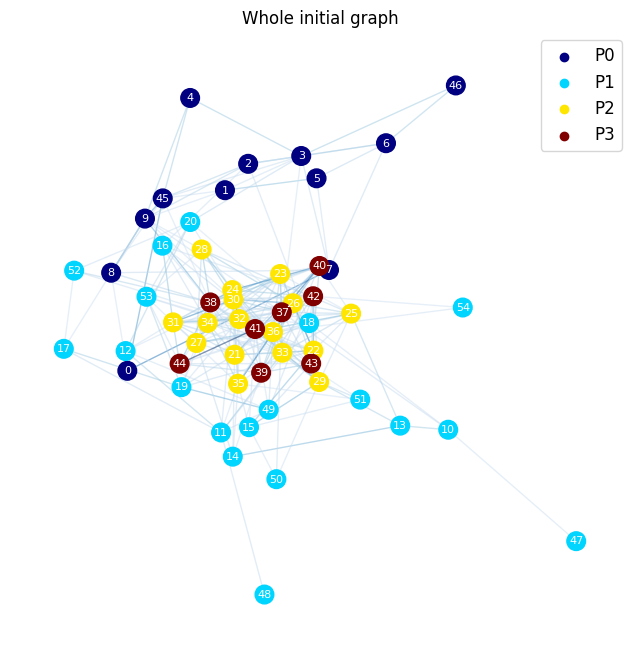

In [11]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=None,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=300, # won't be used here because 1st argument if None
                            plot_node_labels=True,
                            plot_real_node_labels=False,
                            node_labels_size=8,
                            node_label_font_color='white',
                            legend_size=12,
                            save_path=None)

Now let's try to plot, for example, `node_10`. Firstly, we need to find its name after renaming

In [12]:
print(f"Node_10 has id {dp.node_names_to_int_mapping['node_10']} after renaming")

Node_10 has id 8 after renaming


Now let's plot its neighbours

<Figure size 640x480 with 0 Axes>

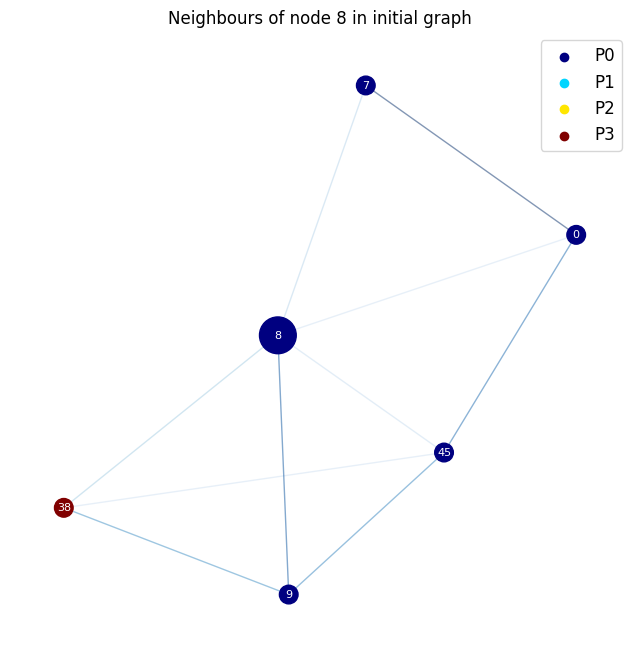

In [13]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=8,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=700,
                            plot_node_labels=True,
                            plot_real_node_labels=False,
                            node_labels_size=8,
                            node_label_font_color='white',
                            legend_size=12,
                            save_path=None)

You can plot real node names as well

<Figure size 640x480 with 0 Axes>

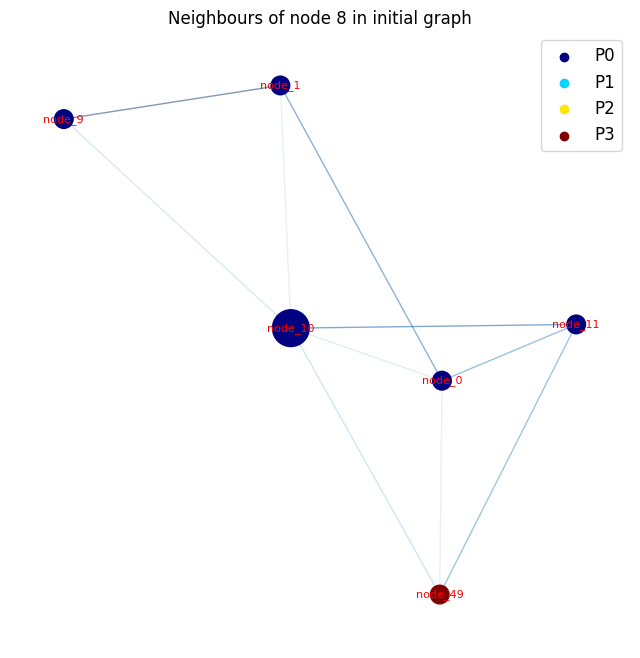

In [14]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=8,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=700,
                            plot_node_labels=True,
                            plot_real_node_labels=True,
                            node_labels_size=8,
                            node_label_font_color='red',
                            legend_size=12,
                            save_path=None)

If you want to access graph in `networkx` format directly, you can do it like that

In [15]:
dp.nx_graph

You can access node attributes of each node and edge like that

In [16]:
print('Some nodes: ', list(dp.nx_graph.nodes)[:10])
print('Some edges: ', list(dp.nx_graph.edges)[:10])
print(f'Node attributes of node "{dp.int_to_node_names_mapping[0]}": ', dp.nx_graph.nodes[0])
print(f'Edge attributes of edge between nodes "{dp.int_to_node_names_mapping[0]}" and "{dp.int_to_node_names_mapping[7]}": ', dp.nx_graph.edges[0, 7])

Some nodes:  [0, 45, 1, 2, 3, 46, 4, 5, 6, 7]
Some edges:  [(0, 45), (0, 7), (0, 8), (45, 1), (45, 2), (45, 3), (45, 4), (45, 8), (45, 9), (45, 38)]
Node attributes of node "node_1":  {'class': 0, 'mask': True}
Edge attributes of edge between nodes "node_1" and "node_9":  {'ibd_sum': 107.36131453757191, 'ibd_n': 1}


You can convert classes of each node to readable names like that

In [17]:
dp.classes[dp.nx_graph.nodes[0]['class']]

'P0'

Suppose you need to visualise matrices with edge probabilities between classes. For that need firstly call `compute_simulation_params` and then `plot_simulated_probs` with the following available parameters:

* `save_path` - path for saving this figure
* `dataset_name` - name of the dataset that will be displayed in title

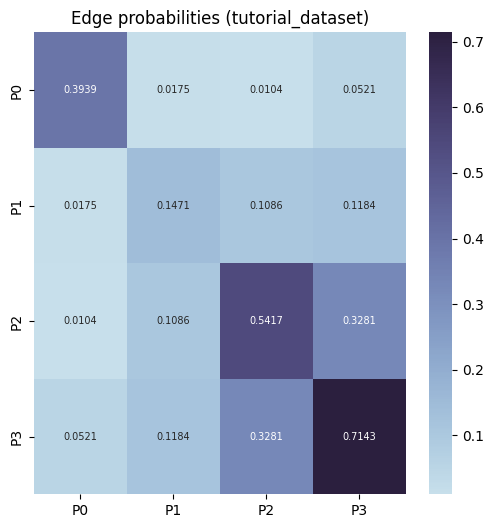

In [18]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='tutorial_dataset')

Visualisation of edge weights can be done the same way (just call function `plot_simulated_weights` with the same parameters)

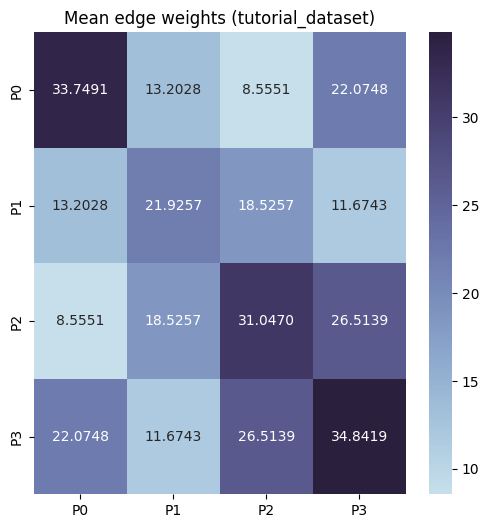

In [19]:
dp.plot_simulated_weights(dataset_name='tutorial_dataset')

To plot edge weight distribution between each class, use function `plot_edge_weight_distribution` with the following parameters:

* `fig_size` - size of the picture
* `dataset_name` - name of the dataset that will be displayed in title
* `title_pos` - you can adjust position of the title with this parameter
* `title_font_size` - you can change font size of title with this parameter
* `save_path` - path for saving this figure
* `custom_class_names` - (list of strings), if your class names are too long, you can assign the list of other class names according to the `dp.classes`
* `fontsize` - you can change font size of labels with this parameter

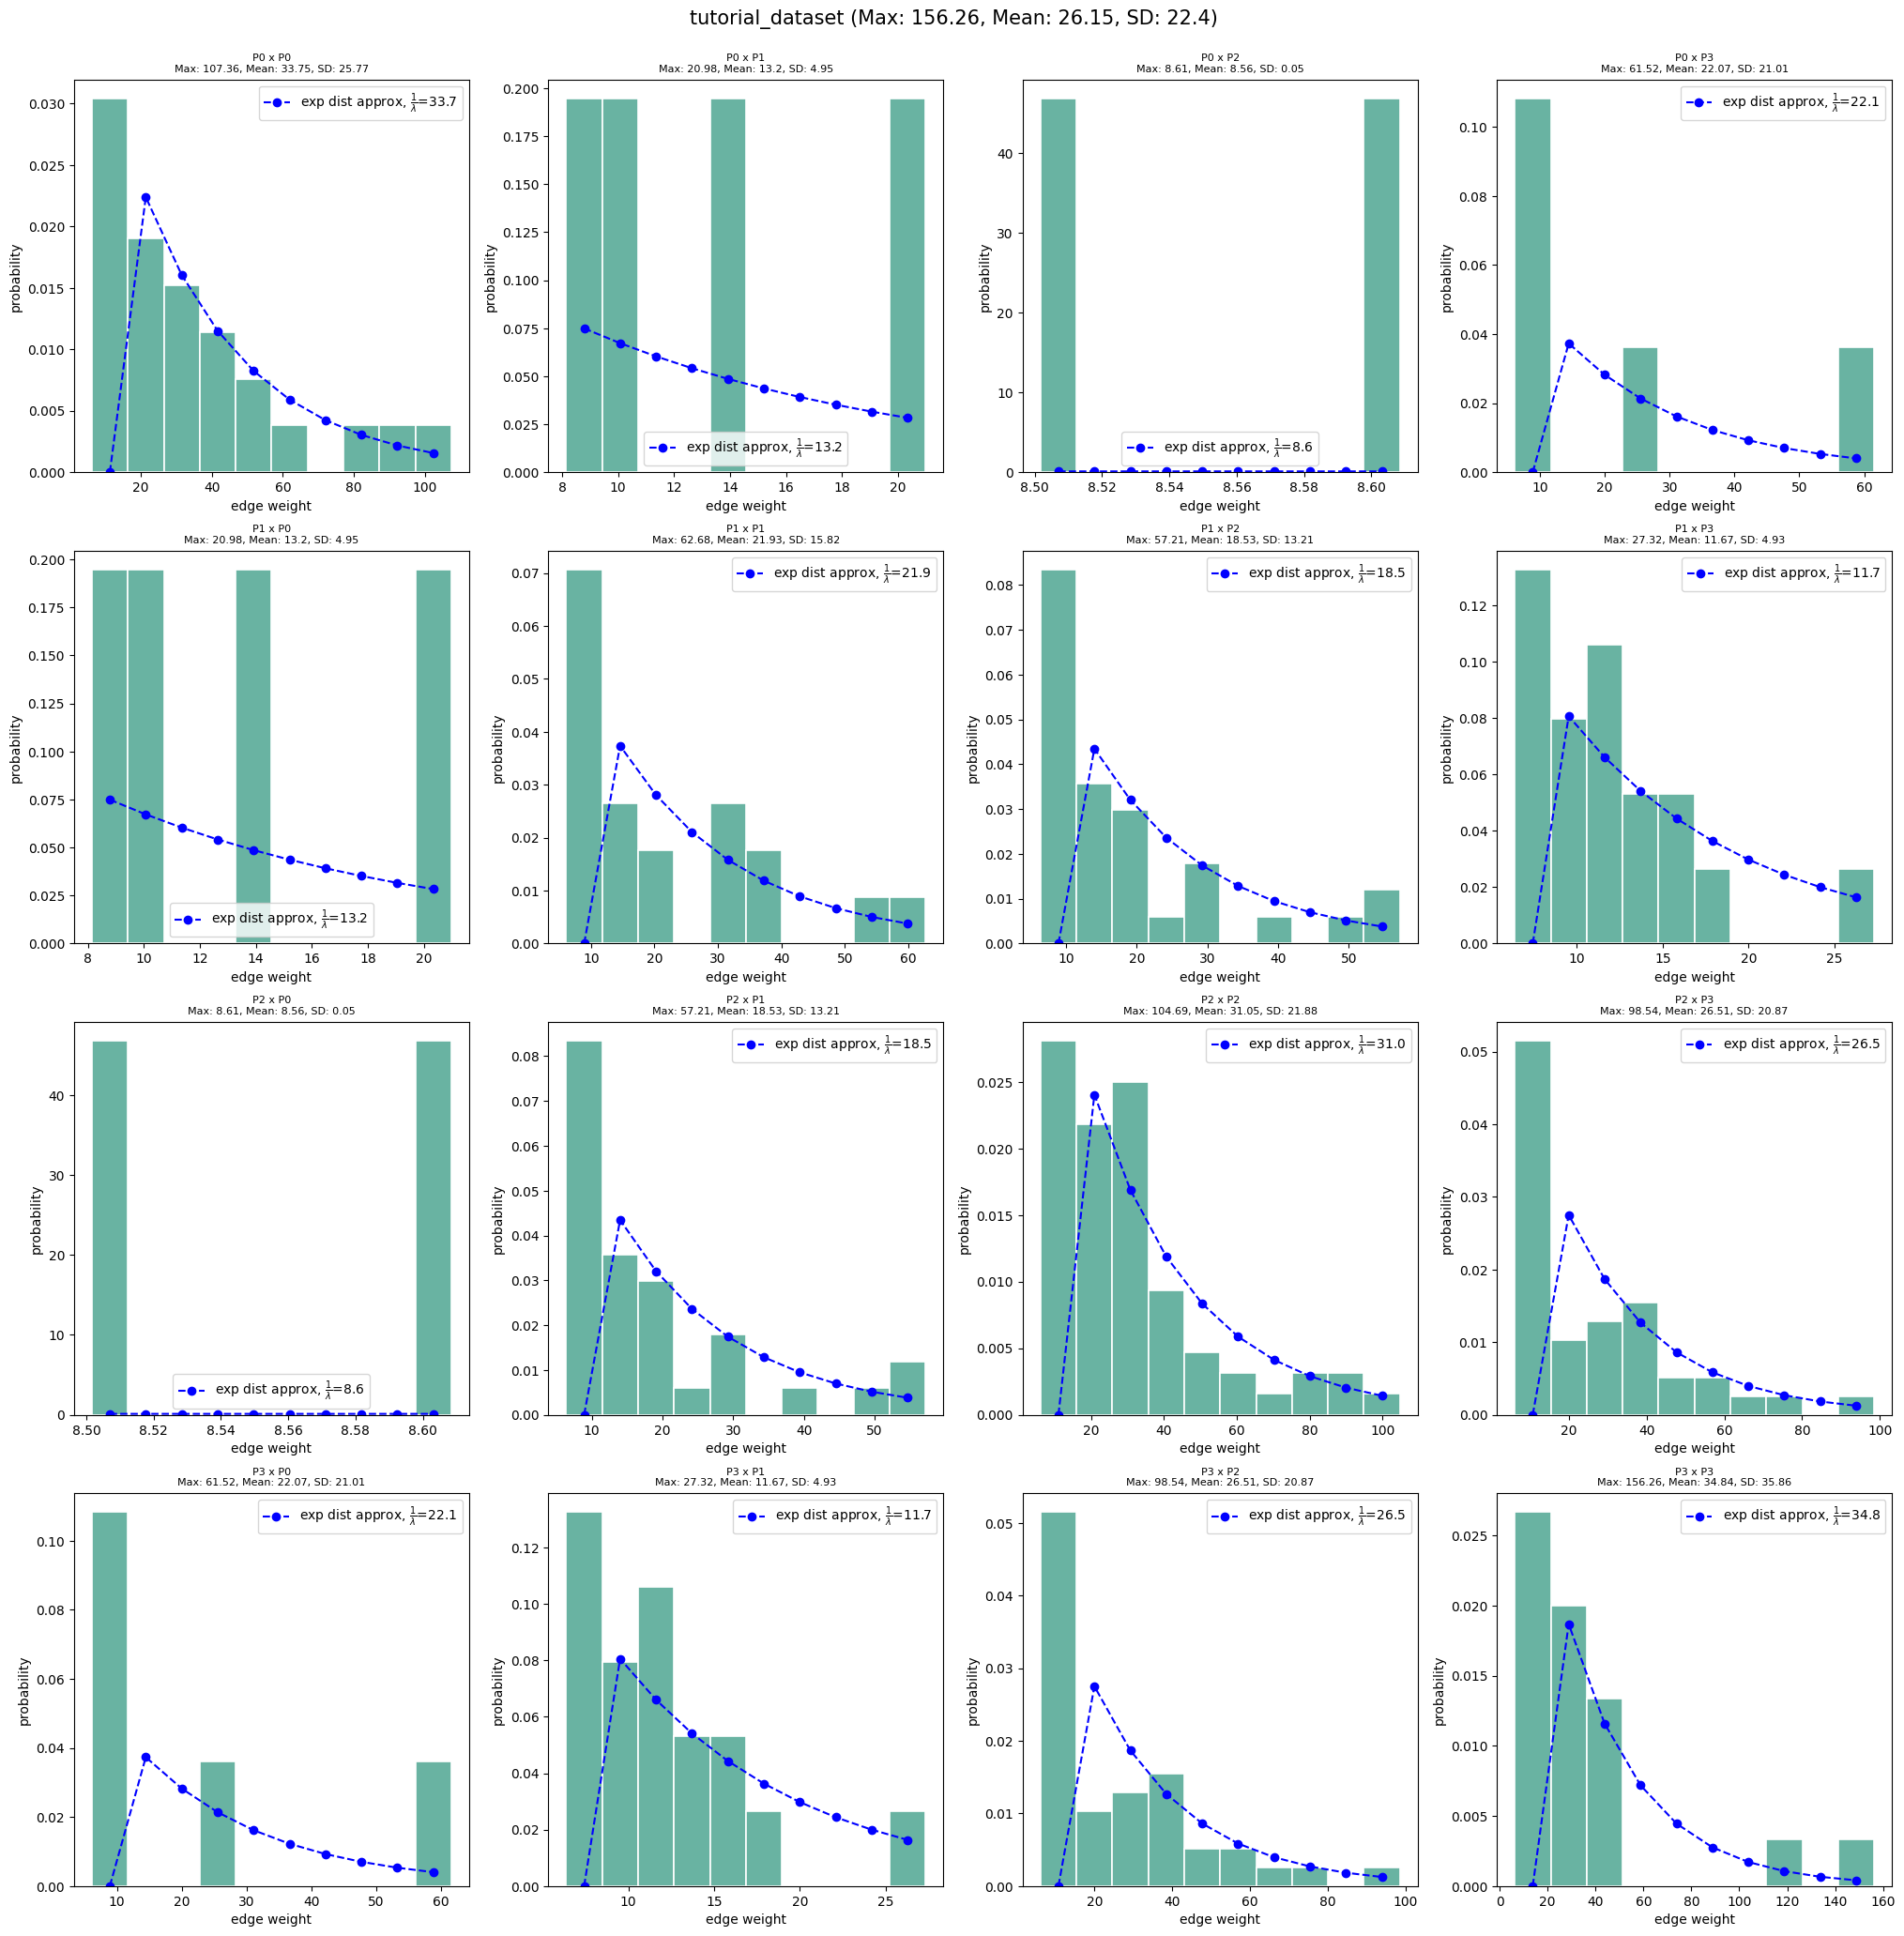

In [20]:
# I always recommend to save all pictures in PDF (just use .pdf at the end of the picture name in path)
dp.plot_edge_weight_distribution(fig_size=(25, 25), 
                                 dataset_name='tutorial_dataset', 
                                 save_path=None,
                                 title_pos=0.91, 
                                 title_font_size=15)

Finally, let's calculate all important characteristics of the graph. You need to call function `get_graph_features` with the following parameters:

* `fig_path` - where to save stats in JSON format as well as generated pictures
* `fig_size` - size of some pictures
* `picture_only` - `True` if you don't want to calculate computationally heavy parameters, `False` otherwise which is default (deprecated)
* `dataset_name` - name of the dataset that will be displayed in title

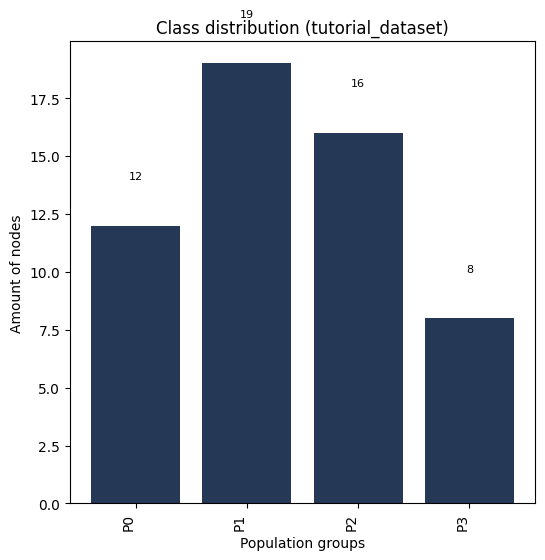

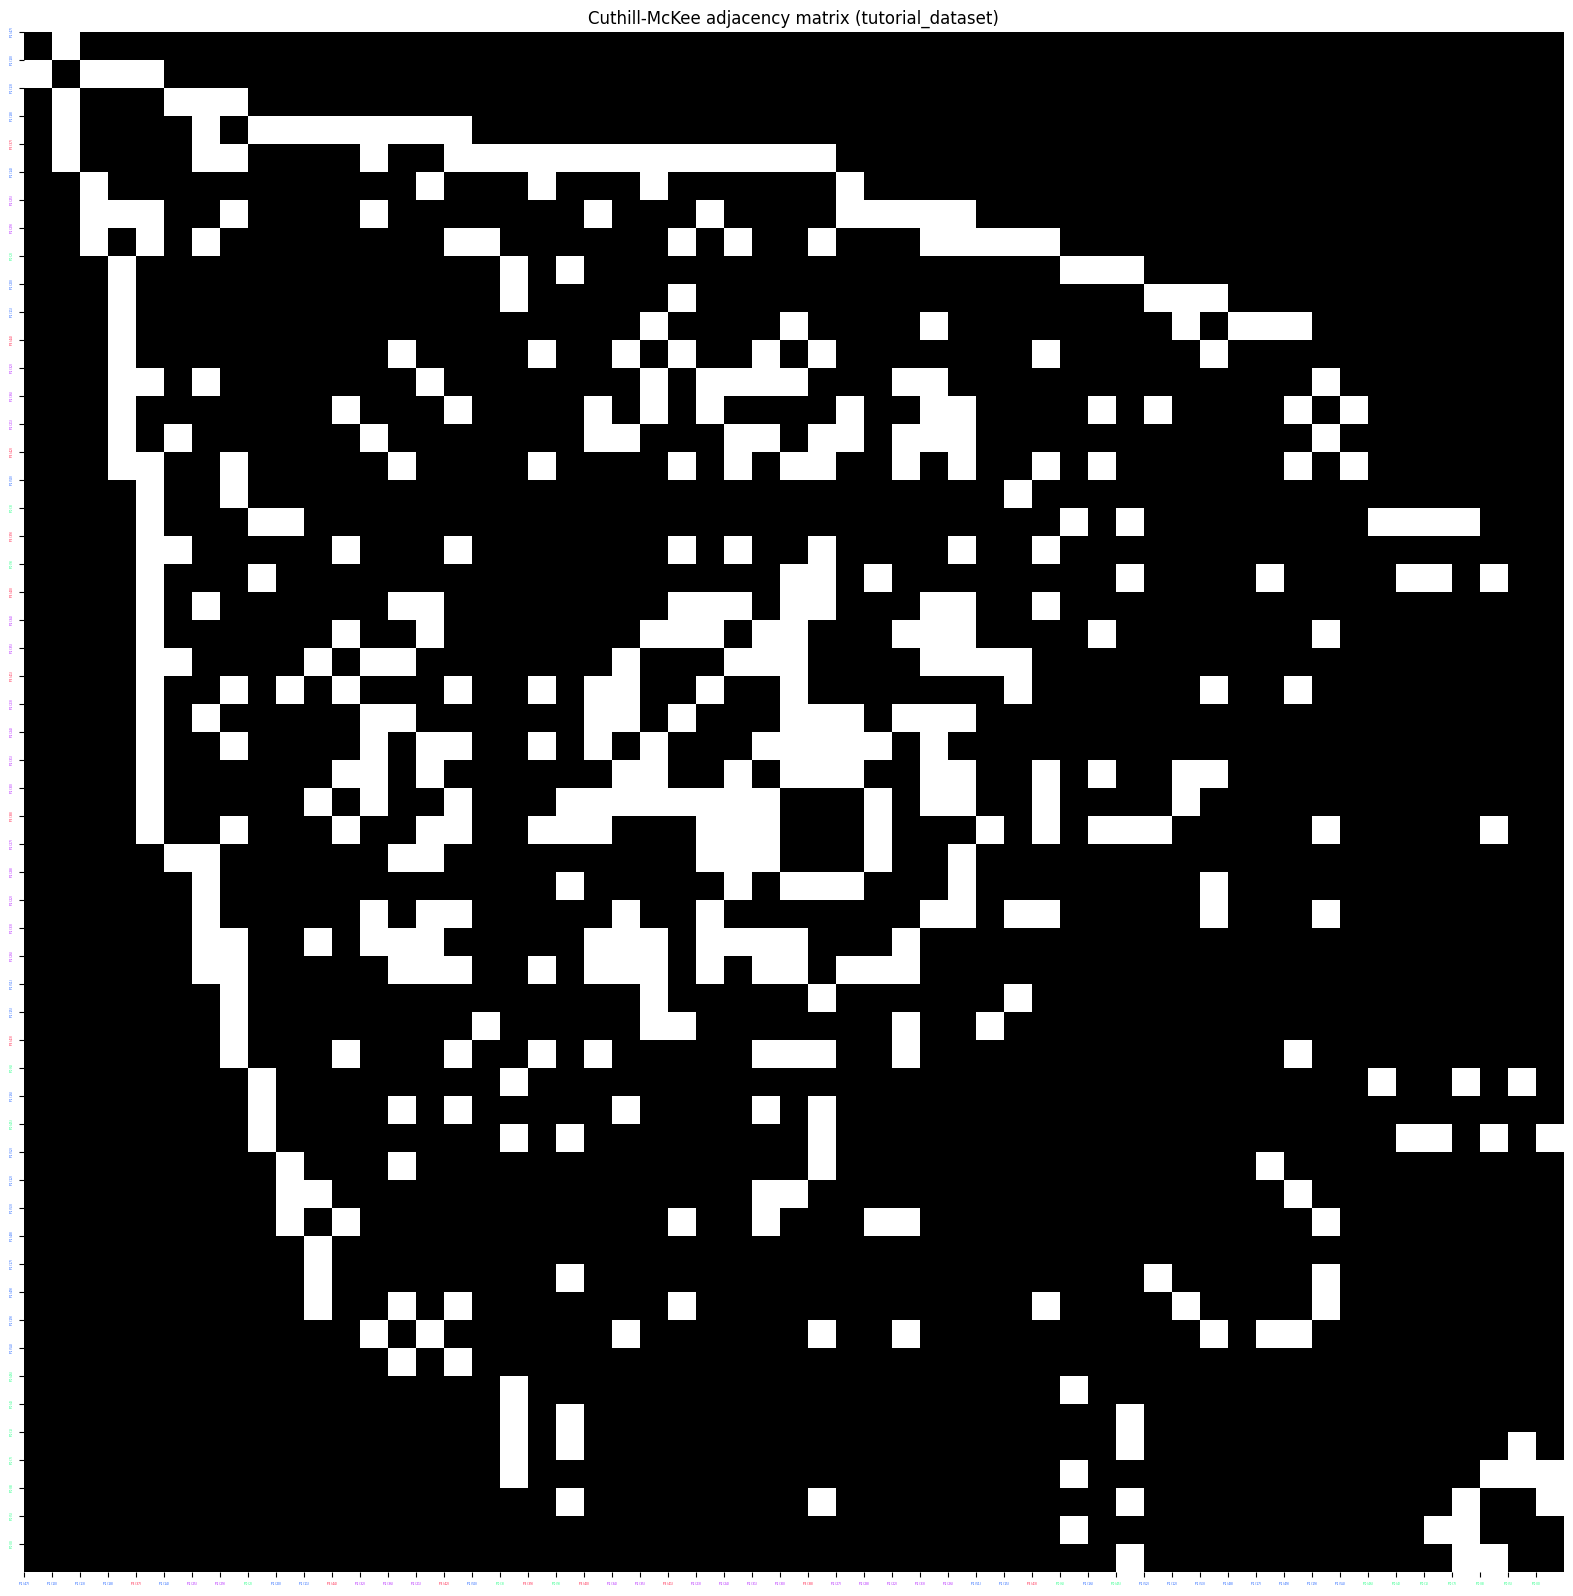

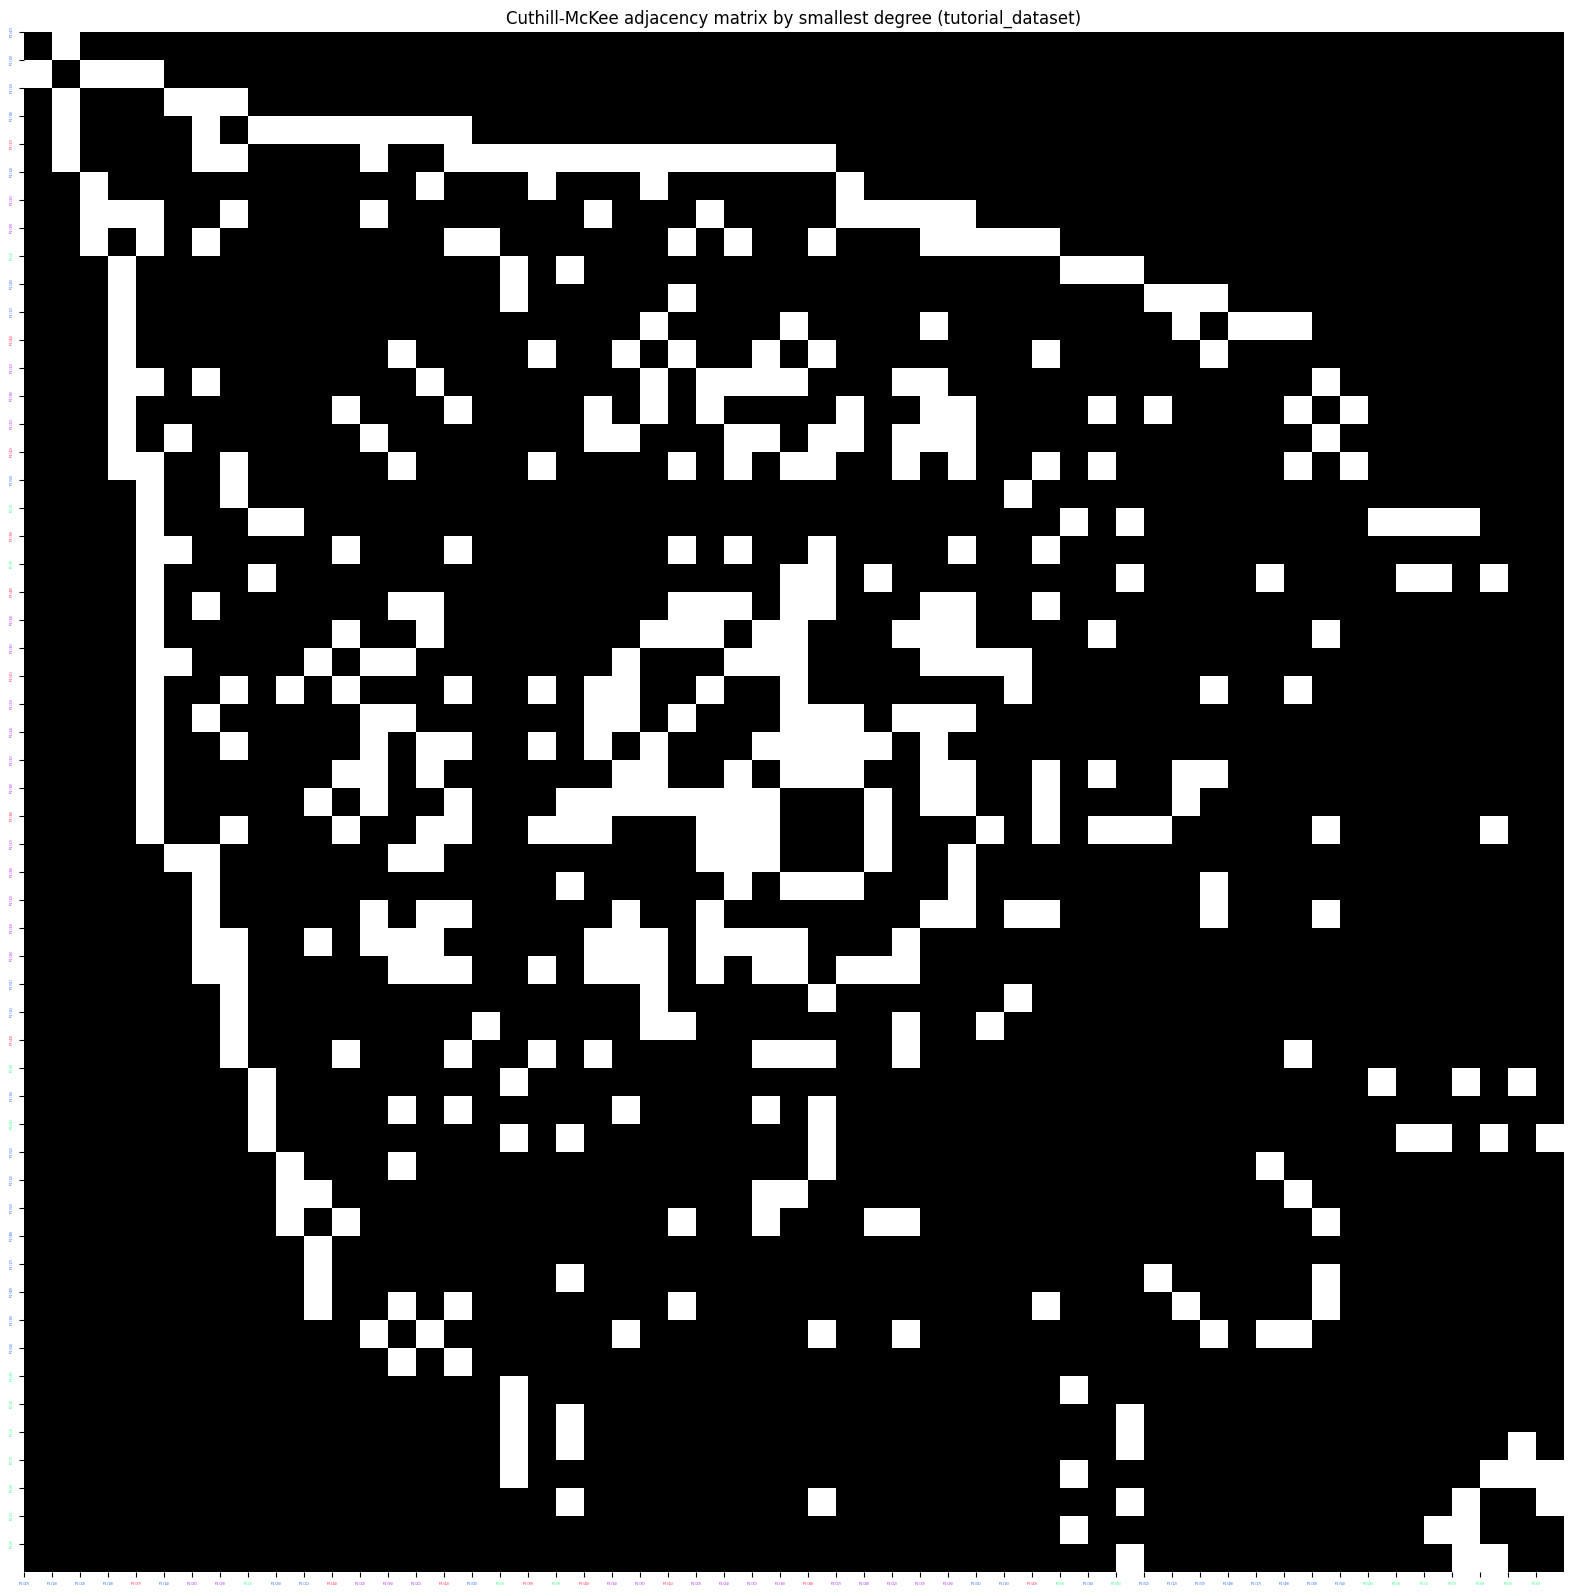

<Figure size 640x480 with 0 Axes>

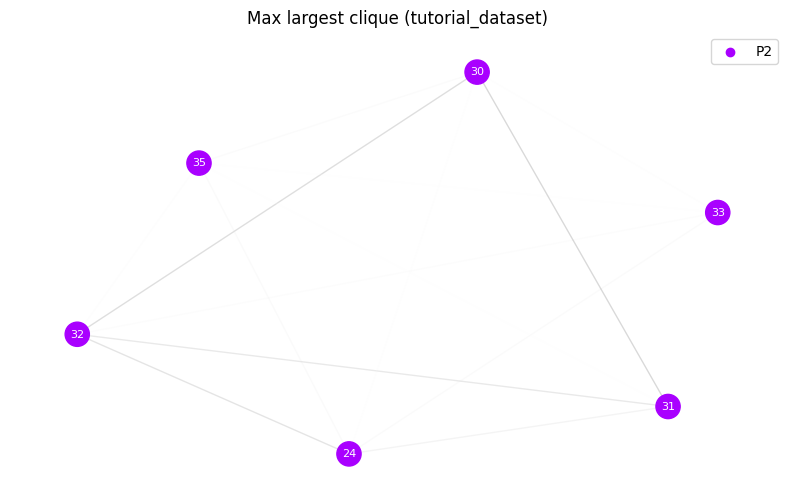

<Figure size 640x480 with 0 Axes>

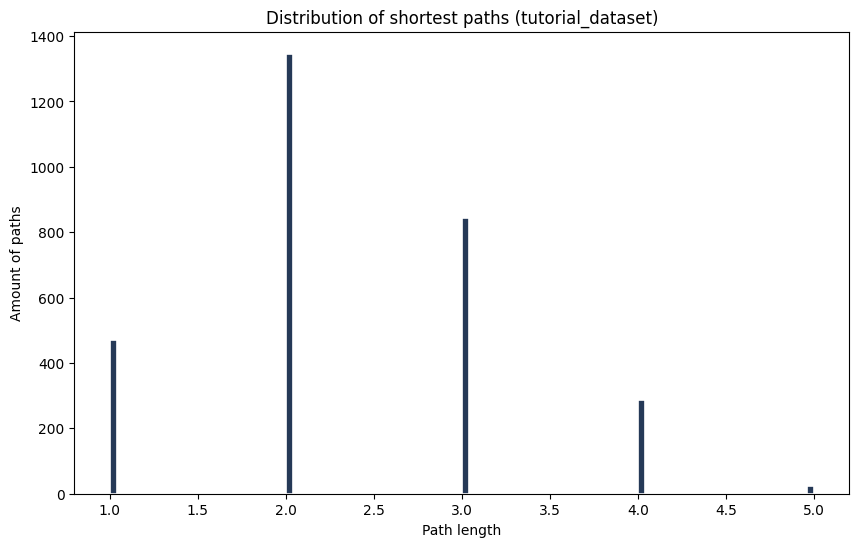

<Figure size 640x480 with 0 Axes>

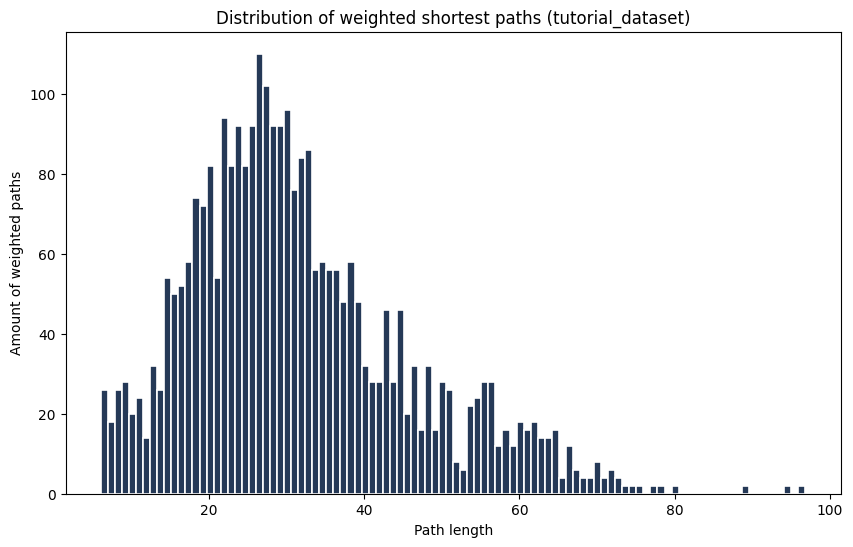

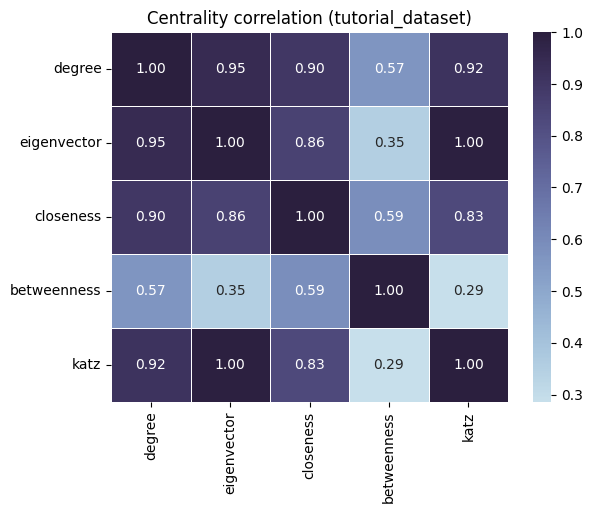

<Figure size 640x480 with 0 Axes>

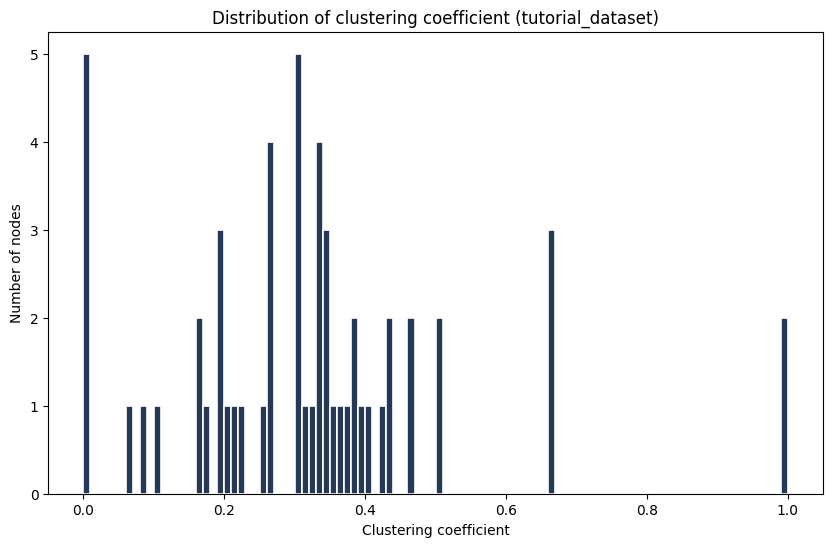

<Figure size 640x480 with 0 Axes>

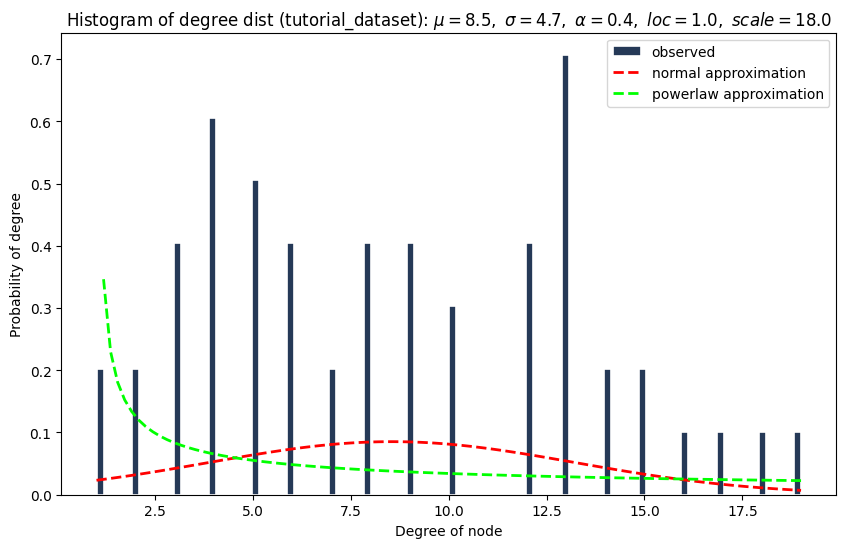

<Figure size 640x480 with 0 Axes>

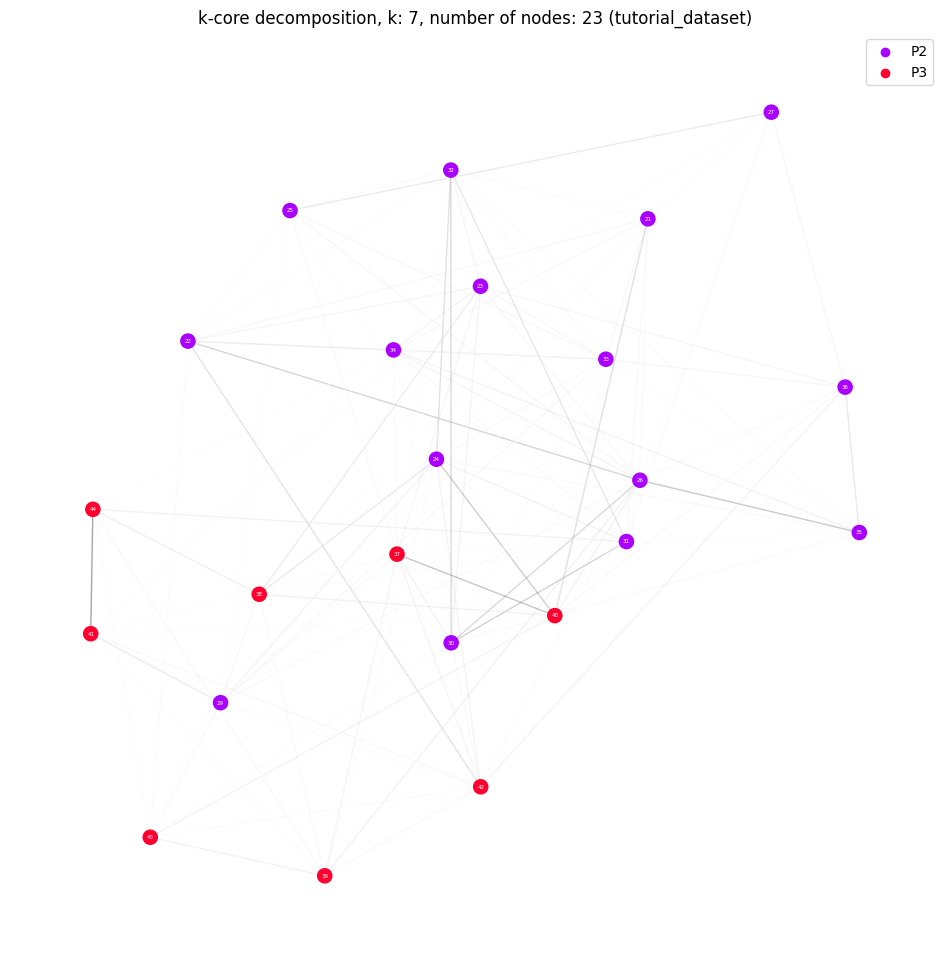

<Figure size 640x480 with 0 Axes>

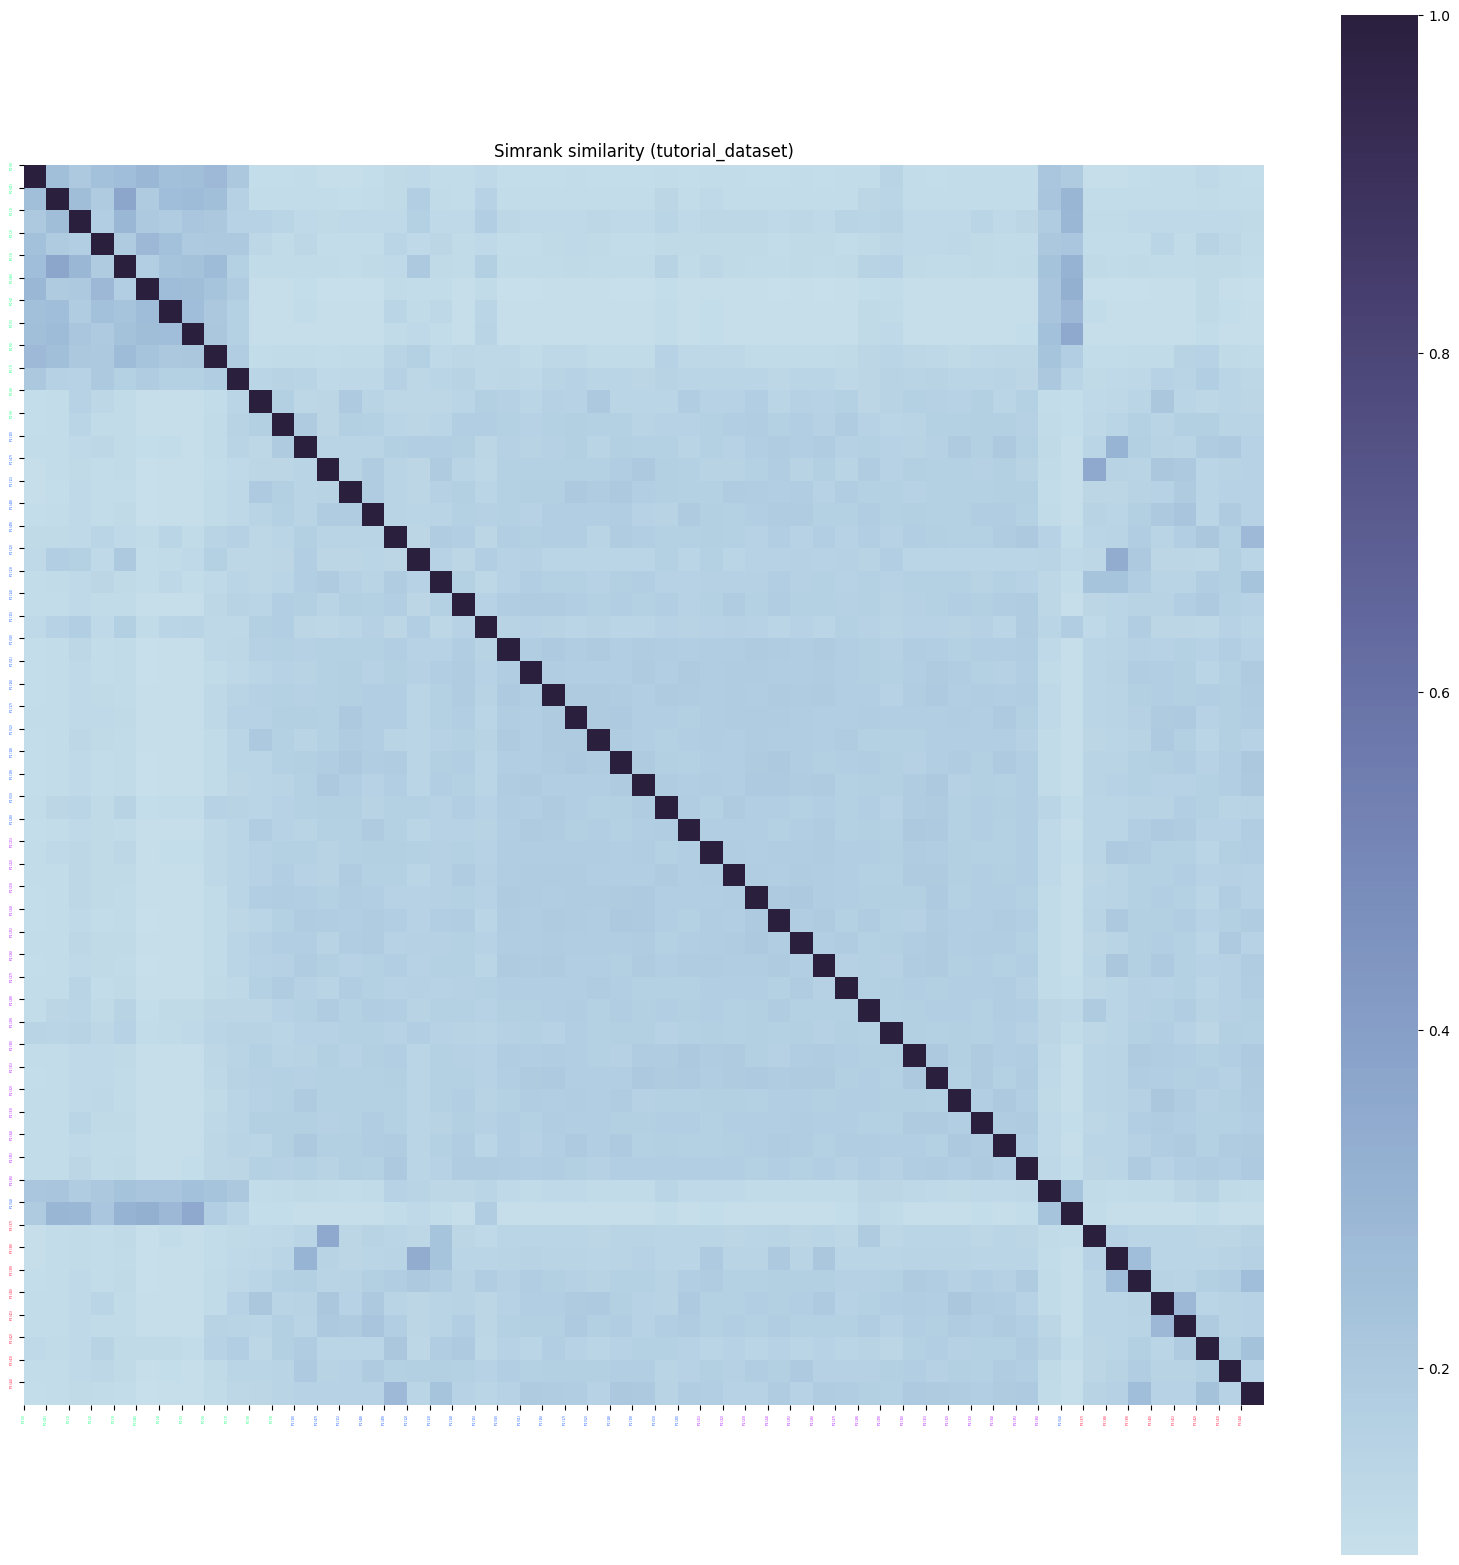

<Figure size 640x480 with 0 Axes>

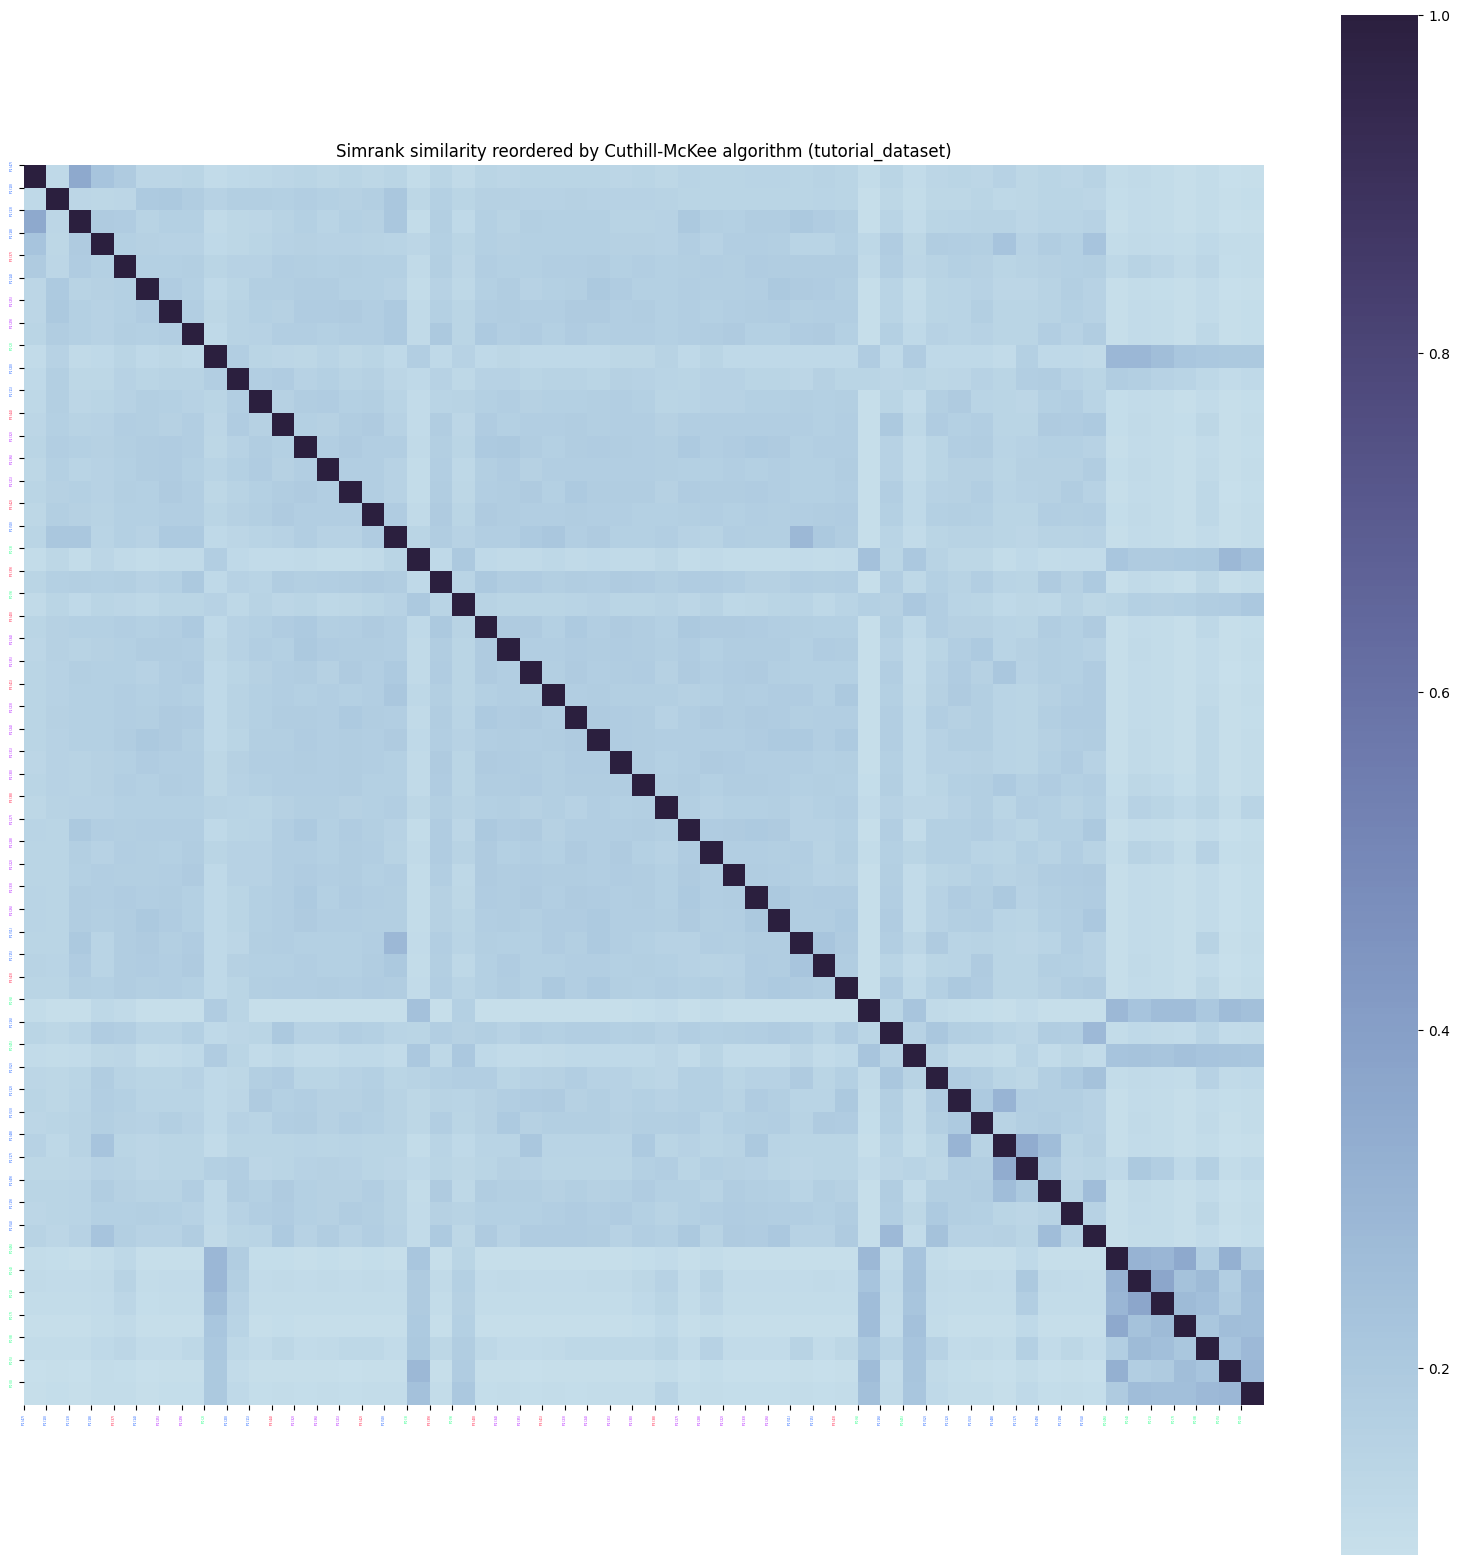

In [21]:
features = dp.get_graph_features(fig_path=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
                                 fig_size=(10, 6), 
                                 dataset_name='tutorial_dataset')

You can see whole bunch of other different parameters in the returned dictionary. See documantation of `networkx` library to find defenitions

In [22]:
features

{'Number of nodes': 55,
 'Number of edges': 235,
 'Density': 0.15824915824915825,
 'Self-loop edges': [],
 'Is connected': True,
 'Number of cc': 1,
 'Number of isolated nodes': 0,
 'Is planar': False,
 'Diameter': 5,
 'Radius': 3,
 'Transitivity': 0.3195789473684211,
 'Number of multi edges': 0,
 'Max degree': 19,
 'Mean degree': 8.545454545454545,
 'Min degree': 1,
 'Global efficiency': 0.5052637485970799,
 'Local efficiency': 0.48875404834347974,
 'Degree assortativity coefficient': 0.2559544578969743,
 'Class assortativity coefficient': 0.3653266853640803,
 'Average clustering': 0.32223176251462204,
 'Center': [9, 18, 20, 30, 37],
 'Periphery': [0, 46, 5, 7, 47, 48, 49, 13, 14, 15, 22, 54],
 'Is Eulerian': False,
 'Is semi-Eulerian': False,
 'Is regular': False,
 'Average shortest path length': 2.342760942760943,
 'Weighted average shortest path length': 31.67957687659728,
 'Is tree': False,
 'Is forest': False,
 'global_clustering_coefficient': 0.6391578947368421,
 'Max degree cen

# Create train/valid/test graphs

In order to train our GNN, we firstly need to specify which nodes we will construct train/valid/test graphs from. You can do it simply by calling `generate_random_train_valid_test_nodes` function with the following parameters (equal class balance of node classes in train/valid/test nodes was already considered):

* `train_size` - percent of nodes for training
* `valid_size` - pervent of node for validation
* `test_size` - percent of node for testing
* `random_state` - seed
* `save_dir` - node splits can be saved to file
* `mask_size` - percent of artificially masked nodes (can be from `0.0` to `1.0`), used only for artificial masking tests
* `sub_train_size` - percent from TRAIN nodes (regulated with `train_size`), remained TRAIN nodes will be used for masking (regulated with `mask_size`), can be from `0.0` to `1.0` but setting it to `1.0` is useless, used only for artificial masking tests
* `keep_train_nodes` - `True` if we want to make nodes, controlled by `sub_train_size`, to be the same across different random seeds, used only for artificial masking tests
* `mask_random_state` - controls which nodes will be considered masked (controlled by `mask_size`), used only for artificial masking tests

In [23]:
# now we're runnsing simple tests without artificial masking, so we can omit most of the parameters
dp.generate_random_train_valid_test_nodes(train_size=0.6,
                                          valid_size=0.2, 
                                          test_size=0.2, 
                                          random_state=seed,
                                          save_dir=None,
                                          mask_size=None,
                                          sub_train_size=None,
                                          keep_train_nodes=None,
                                          mask_random_state=None)

100.0% (55) of all nodes in dataset were used to create splits (no masked nodes assumed)


You can directly access tarin/valid/test split like this

In [24]:
# you can convert those node names to real node names like that were shown above
print(f'Train nodes: {np.array(dp.train_nodes)}')
print(f'Valid nodes: {np.array(dp.valid_nodes)}')
print(f'Test nodes: {np.array(dp.test_nodes)}')

Train nodes: [31  5 32 13 19 49 41 26 43 12 52  3 33 34  8 17  6  4 47 27 46 45 53 15
  9 16 24 30 37 25 11 48 36 40 39]
Valid nodes: [ 0 29  1 21 50 35 44 10 18 54 42]
Test nodes: [ 2 23 22 20  7 14 28 51 38]


You can also load your own splits (for the tutorial purpose we will create a copy of `DataProcessor` object and make further modifications there). Just call the function `load_partitions` with the following arguments:

* `train_socket` - python list with ORIGINAL names of nodes for training
* `valid_socket` - python list with ORIGINAL names of nodes for validation
* `test_socket` - python list with ORIGINAL names of nodes for testing
* `mask_socket` - python list with ORIGINAL names of masked nodes (optional)

In [25]:
dpc = deepcopy(dp)
dpc.load_partitions(train_socket=['node_1', 'node_10', 'node_12', 'node_22', 'node_14'],
                    valid_socket=['node_9', 'node_50', 'node_8'],
                    test_socket=['node_39', 'node_18'],
                    mask_socket=None)

print(f'Train nodes: {np.array(dpc.train_nodes)}')
print(f'Valid nodes: {np.array(dpc.valid_nodes)}')
print(f'Test nodes: {np.array(dpc.test_nodes)}')

Train nodes: [ 0  8 52 13 50]
Valid nodes: [ 7 39  6]
Test nodes: [28 51]


But we've generated only node split, not graphs. In order to generate graphs you can call function `make_train_valid_test_datasets_with_numba` with the following parameters:

* `feature_type` - strictly `one_hot` or `graph_based`, defines type of method for node features generation
* `model_type` - for now it should be always `homogeneous`
* `train_dataset_type` - strictly `multiple` for `one_hot` type of features (argument `feature_type`) and `one` for `graph_based` type of features
* `test_dataset_type` - always `multiple`
* `log_edge_weights` - in case you want genetically normalised edge weights
* `skip_train_val` - create graphs only for testing (skip creation of training and validation graphs)
* `masking` - must be `True` if you want to run experiments with any type of masking, otherwise `False`
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False`
* `make_ram_efficient_dataset` - set `True` (slower but RAM efficient) if you want to same RAM on CPU (not GPU) on you machine, otherwise `False` (faster but uses more RAM)

In [26]:
dp.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=False,
                                             masking=False,
                                             no_mask_class_in_df=True,
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 9/9 [00:00<00:00, 446.47it/s]


You can directly access generated graphs like that

In [27]:
print(dp.array_of_graphs_for_training) # you have multiple training graphs for one_hot node features and only one trainign graph for "graph_based" features
print(dp.array_of_graphs_for_validation)
print(dp.array_of_graphs_for_testing)

[Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], c

You can see that those graphs are not in `networkx` format but in `Data` object of `pytorch_geometric`. You can convert that object back to `networkx` format like that

In [28]:
from torch_geometric.utils import to_networkx
some_train_graph_nx = to_networkx(dp.array_of_graphs_for_training[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
some_train_graph_nx

You can also check that this graph was constructed correctly. Use very powerful function `vf2pp_is_isomorphic` for that (it provides the most accurate isomorphism check)

In [29]:
import networkx as nx
nx.vf2pp_is_isomorphic(nx.subgraph(dp.nx_graph, dp.train_nodes), some_train_graph_nx)

True

You can check all train/validation/test graphs as well

In [30]:
# checking train graphs

for i in range(len(dp.array_of_graphs_for_training)):
    nx.vf2pp_is_isomorphic(nx.subgraph(dp.nx_graph, dp.train_nodes), 
                           to_networkx(dp.array_of_graphs_for_training[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True))

# checking validation graphs

for i, node in enumerate(dp.valid_nodes):
    rg = nx.subgraph(dp.nx_graph, dp.train_nodes + [node])
    mg = to_networkx(dp.array_of_graphs_for_validation[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

# checking test graphs

for i, node in enumerate(dp.test_nodes):
    rg = nx.subgraph(dp.nx_graph, dp.train_nodes + [node])
    mg = to_networkx(dp.array_of_graphs_for_testing[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

# Training

In order to run appropriate training, you need only one class `Trainer` that does everything for you. Pay attantion to all its arguments:

* `data` - your `DataProcessor` object
* `model_cls` - class of your GNN
* `lr` - desired learning rate
* `wd` - desired weight decay
* `loss_fn` - class of loss function
* `batch_size` - all your generated graphs are loaded on GPU not one by one, this parameters regulates how many graph will be loaded to CPU during single iteration, this parameter does not afect training on CPU
* `log_dir` - metrics will be saved here after training
* `patience` - how long should we wait till the training stop if metrics in validation garphs do not increase
* `num_epochs` - should be (int) for `one_hot` node features and `None` for `graph_based` features, it represents the number of epochs for training only on graphs with `one_hot` node features
* `feature_type` - strictly `one_hot` or `graph_based`, defines type of method for node features generation
* `train_iterations_per_sample` - shuld be (int) for `graph_based` node features and `None` for `one_hot` features, it represents the number of iteration for training only on graphs with `graph_based` node features
* `evaluation_steps` - should be (int), representing after what amount of iterations you should run validation each time
* `weight` - loss weights, should be torch tensor with the same amount of elements as the amount of you populations
* `masking` - must be `True` if you use training with masked nodes, otherwise `False`
* `cuda_device_specified` - you can specify CUDA device ID that well be used for trainign network (int)
* `disable_printing` - should be `True` if you want to supress almost all logs, otherwise `False`
* `seed` - seed
* `save_model_in_ram` - `True` if you want to save you model in RAM after training is finished and the best model is obtained, otherwise `False`
* `correct_and_smooth` - `True` if you want to combine GNN with Label Propagation, otherwise `False` (we recommend always keep it `False`)
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False`
* `remove_saved_model_after_testing` - during training your intermediate checkpoint of the model is saved in you `log_dir`, if `True`, the best checkpoint will be deleted after training, if `False` the best checkpoint will be retained
* `plot_cm` - you can plot confusion matric on test graphs after training (set it as `True` then)
* `use_class_balance_weight` - use loss weights according to representation of each class (great for imbalances datasets)
* `num_workers` - how many workers to use in DataLoader (int)

In [31]:
import torch
trainer = Trainer(data=dp,
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, 
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=False, 
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=True,
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance


Now run and you're done!

Training for data: tutorial_dataset


Compute metrics: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.29      0.67      0.40         3
           3       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.07      0.17      0.10        11
weighted avg       0.08      0.18      0.11        11

f1 macro score on valid dataset for class 0 which is P0: 0.0
f1 macro score on valid dataset for class 1 which is P1: 0.0
f1 macro score on valid dataset for class 2 which is P2: 0.4
f1 macro score on valid dataset for class 3 which is P3: 0.0
f1 macro improvement to 0.1


Training epochs:  10%|█         | 1/10 [00:05<00:49,  5.46s/it]

Mean loss: 0.5113294124603271




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 32.52it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:01<00:00, 30.17it/s, val_best_score=0.1]





Training epochs:  20%|██        | 2/10 [00:06<00:23,  2.88s/it]

Mean loss: 0.20872487127780914


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 32.51it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 1th time


Training epochs:  30%|███       | 3/10 [00:07<00:14,  2.08s/it]

Mean loss: 0.13923047482967377




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 34.51it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 2th time



Training samples: 100%|██████████| 35/35 [00:01<00:00, 31.91it/s, val_best_score=0.9]





Training epochs:  40%|████      | 4/10 [00:08<00:10,  1.68s/it]

Mean loss: 0.07811930030584335


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 31.05it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999


Training epochs:  50%|█████     | 5/10 [00:09<00:07,  1.48s/it]

Mean loss: 0.044098999351263046




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 32.20it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:01<00:00, 32.40it/s, val_best_score=0.9]





Training epochs:  60%|██████    | 6/10 [00:10<00:05,  1.35s/it]

Mean loss: 0.034016288816928864


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 33.19it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 1th time


Training epochs:  70%|███████   | 7/10 [00:12<00:03,  1.26s/it]

Mean loss: 0.04453390836715698




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 34.53it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:01<00:00, 31.75it/s, val_best_score=0.9]





Training epochs:  80%|████████  | 8/10 [00:13<00:02,  1.20s/it]

Mean loss: 0.04188748821616173


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 32.45it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       0.67      0.67      0.67         3
           3       0.33      0.50      0.40         2

    accuracy                           0.73        11
   macro avg       0.75      0.73      0.73        11
weighted avg       0.79      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.6666666666666666
f1 macro score on valid dataset for class 3 which is P3: 0.4
Metric was not improved for the 1th time


Training epochs:  90%|█████████ | 9/10 [00:14<00:01,  1.16s/it]

Mean loss: 0.08866855502128601




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 39.89it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:01<00:00, 33.49it/s, val_best_score=0.9]





Training epochs: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Mean loss: 0.020671023055911064


Compute metrics: 100%|██████████| 9/9 [00:00<00:00, 30.04it/s]


Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

f1 macro score on test dataset: 1.0
f1 weighted score on test dataset: 1.0
recall macro score on test dataset: 1.0
recall weighted score on test dataset: 1.0
recall macro score on test dataset: 1.0
recall weighted score on test dataset: 1.0
accuracy score on test dataset: 1.0
f1 macro score on test dataset for class 0 which is P0: 1.0
f1 macro score on test dataset for class 1 which is P1: 1.0
f1 macro score on test dataset for class 2 which is P2: 1.0
f1 macro score on test dataset for class 3 which is P3: 1.0


Training samples: 100%|██████████| 35/35 [00:01<00:00, 25.68it/s, val_best_score=0.9]


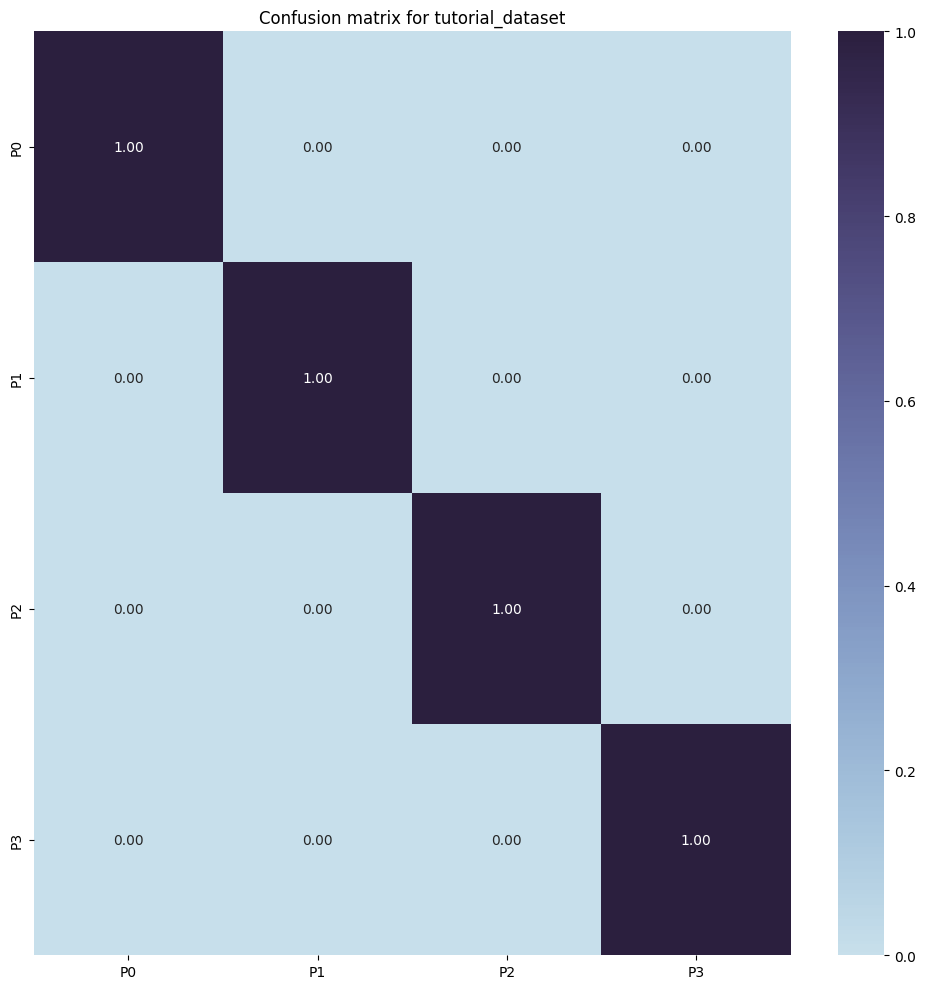

In [32]:
results = trainer.run()

In [33]:
# this variable will store all obtained metrics
# skipped_nodes - number of test nodes that became isolated during train/val/test split
# class_scores - f1 score per class
results

{'f1_macro': 1.0,
 'f1_weighted': 1.0,
 'precision_macro': 1.0,
 'precision_weighted': 1.0,
 'recall_macro': 1.0,
 'recall_weighted': 1.0,
 'accuracy': 1.0,
 'class_scores': {'P0': 1.0, 'P1': 1.0, 'P2': 1.0, 'P3': 1.0},
 'skipped_nodes': 0,
 'memory_allocated_MB': 36.6865234375,
 'memory_reserved_MB': 46.0}

In order to visualise predictions of the model, simply call the function `visualize_predictions` with the following parameters:

* `model` - your trained model
* `test_graph` - the graph in `Data` object format that you want to visualise
* `test_node` - relabeled node name (see code cell below to understand how to get it)
* `base_node_size` - size of nodes
* `selected_node_size` - size of specified node
* `node_labels` - can be `None` if you don't want to plot node labels, `"dataset"` if you want to plot relabeled node names, `"real"` if you want to plot real node names
* `node_labels_size` - size of node labels
* `node_label_font_color` - color of nodel labels
* `use_component` - `True` if you want to visualise the whole component of the graph with test node, `False` otherwise (will be visualised only neighbours of the test node)

In [34]:
the_graph_i_want_to_see = 0
print(f'Current test node: {dp.test_nodes[the_graph_i_want_to_see]}, assign this values to test_node variable below')

Current test node: 2, assign this values to test_node variable below


/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1886: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')
/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1887: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


Number of initial nodes: 36
Number of final nodes: 6


<Figure size 640x480 with 0 Axes>

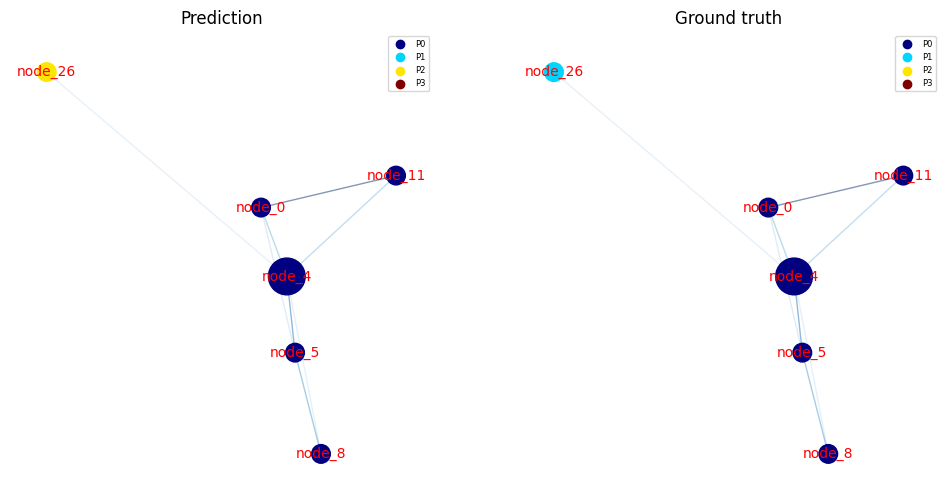

In [35]:
dp.visualize_predictions(model=trainer.model,
                         test_graph=dp.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=2, 
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=False)

# Prediction on custom graphs

Now we know how to train, validate and test our model, visualise predictions and compute graph parameters. But we were working with predefined full graph. What if we want to validate our trained model on a completely new graph that was not presented in initial graph by any chance? Firstly, let's create such a new graph by adding node "node_test" (you can use whatever node name you want) and connect it to some nodes from the **training graph**

In [49]:
# here is how you can get processed dataframe
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,0,45,0,0,79.181347,1
1,1,45,0,0,9.701131,1
2,2,45,0,0,28.309291,1
3,3,45,0,0,14.826807,1
4,3,1,0,0,11.424783,1
...,...,...,...,...,...,...
230,44,36,3,2,6.396516,1
231,44,38,3,3,46.897711,1
232,44,39,3,3,25.709908,1
233,44,41,3,3,156.257226,1


In [50]:
# here is our originally simulated dataset
df_init = pd.read_csv(graph_file_path)
df_init

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
230,node_55,node_47,P3,P2,6.396516,1
231,node_55,node_49,P3,P3,46.897711,1
232,node_55,node_50,P3,P3,25.709908,1
233,node_55,node_52,P3,P3,156.257226,1


Let's add edges between "node_test" and "node_5", "node_6", "node_7", "node_50". But before doing this we need to check were those nodes in train graph

In [51]:
df_init.iloc[[6, 7, 8, 9, 232]]

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
6,node_5,node_4,P0,P0,47.332943,1
7,node_6,node_0,P0,P0,35.709737,1
8,node_6,node_5,P0,P0,37.841436,1
9,node_7,node_2,P0,P0,46.932892,1
232,node_55,node_50,P3,P3,25.709908,1


In [52]:
for node in ['node_5', 'node_6', 'node_7', 'node_50']:
    assert dp.node_names_to_int_mapping[node] in dp.train_nodes

In [53]:
# here we create new sub dataframe with new node "node_test", you MUST assign whatever class to such nodes (prediction will not depend on it because it will be a test node),
# those classes MUST be from existing one in dataset
df_add = pd.DataFrame({'node_id1':['node_test', 'node_test', 'node_test', 'node_50'], 
                       'node_id2':['node_5', 'node_6', 'node_7', 'node_test'], 
                       'label_id1':['P1', 'P1', 'P1', 'P3'], # let's assign P1 as "fake ground truth" class for our node_test
                       'label_id2':['P0', 'P0', 'P0', 'P1'], # let's assign P1 as "fake ground truth" class for our node_test
                       'ibd_sum':[10.0, 10.0, 10.0, 10.0], # we use arbitrary values here just as example
                       'ibd_n':[1, 1, 1, 1]})
df_add

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_test,node_5,P2,P0,10.0,1
1,node_test,node_6,P2,P0,10.0,1
2,node_test,node_7,P2,P0,10.0,1
3,node_50,node_test,P3,P2,10.0,1


In [54]:
# now we merge all those dataframes
df_mod = pd.concat([df_init, df_add], axis=0)
df_mod = df_mod.reset_index(drop=True)
df_mod

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
234,node_55,node_54,P3,P3,15.175590,1
235,node_test,node_5,P2,P0,10.000000,1
236,node_test,node_6,P2,P0,10.000000,1
237,node_test,node_7,P2,P0,10.000000,1


In [55]:
# now we need to create new DataProcessor object using megred dataframe
dpm = DataProcessor(path=df_mod,
                    is_path_object=True,
                    disable_printing=False,
                    dataset_name='new_node_dataset',
                    no_mask_class_in_df=True)

Good. Now we need to construct graph using `Data` object. It can be done using the same functions that we discussed before

In [56]:
# Firstly, we need to load train and test nodes in our new DataProcessor object (dpm), we don't set up masked nodes here
# However, if you have real masked nodes, you can load them in mask_socket as well
# By using the same logic you can set up multiple new nodes (like node_test), they will be evaluated independently
dpm.load_partitions(train_socket=[dp.int_to_node_names_mapping[node] for node in dp.train_nodes],
                    valid_socket=[],
                    test_socket=['node_test'])

In [57]:
# making graphs in Data object, as usually but setting skip_train_val to True
dpm.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=True, # keep it in mind
                                             masking=False,
                                             no_mask_class_in_df=True,
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 1/1 [00:00<00:00, 237.72it/s]


In [58]:
# make sure the core of the graph (that should consist only from the train nodes) is the same as in dp object (not dpm object)

dpm_test_graph = to_networkx(dpm.array_of_graphs_for_testing[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
dp_train_graph = to_networkx(dp.array_of_graphs_for_training[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)

dpm_test_graph_core = nx.subgraph(dpm_test_graph, list(range(len(dpm_test_graph.nodes) - 1))) # we can do this because validation and test nodes always have the last idx in graph, so we just substract 1

assert nx.vf2pp_is_isomorphic(dp_train_graph, dpm_test_graph_core)

Time to get prediction for each our new test nodes independently (in our case number of nodes is 1)!!! Set up new Trainer with the same parameters but with different DataProcessor object

In [59]:
trainer_test = Trainer(data=dpm, # pay attention here
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, # same model class is crucial
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=False, 
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=True,
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance


And now we need to call `load_model_and_get_predictions` function with a single argument:

* `path` - path to the checkpoin of the model

In [60]:
answers = trainer_test.load_model_and_get_predictions(path=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/model_best.bin')

As the result, you get the dictionary with keys as your test graphs id and values as another dictionary with the following attributes:

* `answer_class` - prediction in readable format (your actual classes)
* `answer_id` - prediction in relabeled classes
* `probabilities` - class probabilities

In [61]:
answers

{'test_graph_0': {'answer_class': 'P0',
  'answer_id': 0,
  'probabilities': array([9.9858946e-01, 3.2147698e-04, 3.4185774e-05, 1.0548262e-03],
        dtype=float32)}}